## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.1) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

101077
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

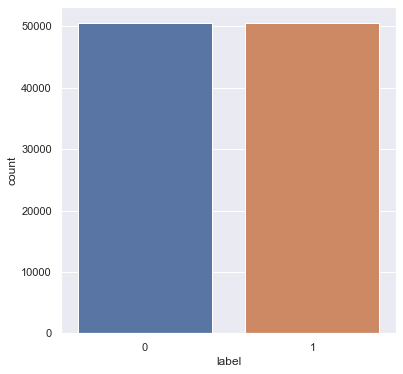

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

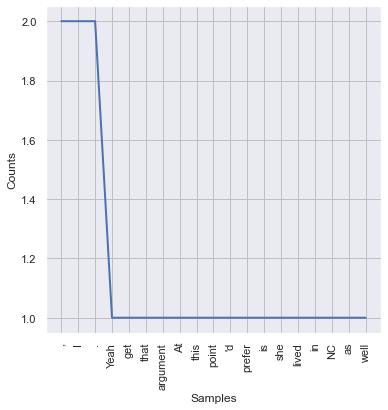

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'be', 'against', 'some', "mightn't", 'not', 'wouldn', 'how', 'being', 'or', 'no', 'there', 'doing', 'between', 'such', 'she', 'if', 'isn', 'll', 'through', "shouldn't", 'out', 'then', 'while', "needn't", "wasn't", 'a', 'your', "should've", 'me', "didn't", 'didn', 'their', 'any', 'from', 'of', 'had', 'ma', 'again', 'has', 'further', 'ain', 'very', "wouldn't", 'during', 'my', 'd', 'in', 'before', 'ourselves', 'that', 'couldn', 'yourselves', 'y', 'himself', 'were', 'this', "you'll", "aren't", 'which', 'here', 'just', 'itself', 'at', 'weren', 'when', 'have', 'an', 'about', 'shouldn', 'ours', 'mustn', 'hers', 'its', 'each', "hadn't", 'on', "don't", 'most', 'it', 'both', 'by', "isn't", "weren't", "you're", 'below', 'haven', 'is', 'why', "hasn't", 'now', 'same', 'they', 'wasn', 'own', 'themselves', 'where', "won't", 'for', "you've", 'hasn', 'under', 'yourself', 'too', 'off', 'needn', 'am', 'won', 'and', 'i', 'down', 'than', 'm', 'you', 'what', 'aren', 'as', 'over', 'the', 'so', 'can', 'might

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dependency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

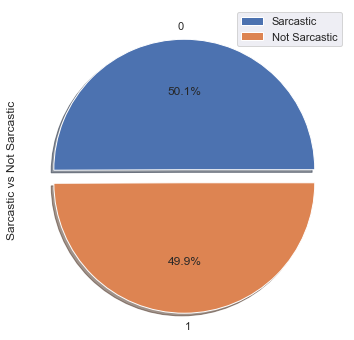

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

74141

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

5578

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,--------__--------,1,1
1,------___--___------,0,1
2,------___--___------,1,1
3,-----BroAway-----,1,1
4,----branflakes----,1,1
...,...,...,...
85658,zzz_lll_zzz,0,1
85659,zzzhhh123,0,1
85660,zzzhhh123,1,1
85661,zzzzzzzzzzzzzzzzspaf,0,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
--------__--------,1
------___--___------,1
-----BroAway-----,1
----branflakes----,1
---_--_---,0
...,...
zzt711,2
zzyul,0
zzz_lll_zzz,0


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,--------__--------,1
1,------___--___------,2
2,-----BroAway-----,1
3,----branflakes----,1
4,---_--_---,1
...,...,...
74136,zzt711,3
74137,zzyul,1
74138,zzz_lll_zzz,1
74139,zzzhhh123,2


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,--------__--------,1,1
1,------___--___------,1,2
2,-----BroAway-----,1,1
3,----branflakes----,1,1
4,---_--_---,0,1
...,...,...,...
74136,zzt711,2,3
74137,zzyul,0,1
74138,zzz_lll_zzz,0,1
74139,zzzhhh123,1,2


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,--------__--------,1,1,1.000000
1,------___--___------,1,2,0.500000
2,-----BroAway-----,1,1,1.000000
3,----branflakes----,1,1,1.000000
4,---_--_---,0,1,0.000000
...,...,...,...,...
74136,zzt711,2,3,0.666667
74137,zzyul,0,1,0.000000
74138,zzz_lll_zzz,0,1,0.000000
74139,zzzhhh123,1,2,0.500000


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100thieves,0,1
1,100thieves,1,2
2,1022,1,1
3,10cloverfieldlane,1,4
4,11bx1371,0,1
...,...,...,...
7961,zelda,1,6
7962,zenfone2,1,1
7963,zombies,0,4
7964,zootopia,0,4


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100thieves,2
1022,1
10cloverfieldlane,4
11bx1371,0
1200isplenty,1
...,...
zedmains,1
zelda,6
zenfone2,1


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100thieves,3
1,1022,1
2,10cloverfieldlane,4
3,11bx1371,1
4,1200isplenty,7
...,...,...
5573,zedmains,1
5574,zelda,14
5575,zenfone2,1
5576,zombies,4


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100thieves,2,3
1,1022,1,1
2,10cloverfieldlane,4,4
3,11bx1371,0,1
4,1200isplenty,1,7
...,...,...,...
5573,zedmains,1,1
5574,zelda,6,14
5575,zenfone2,1,1
5576,zombies,0,4


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100thieves,2,3,0.666667
1,1022,1,1,1.000000
2,10cloverfieldlane,4,4,1.000000
3,11bx1371,0,1,0.000000
4,1200isplenty,1,7,0.142857
...,...,...,...,...
5573,zedmains,1,1,1.000000
5574,zelda,6,14,0.428571
5575,zenfone2,1,1,1.000000
5576,zombies,0,4,0.000000


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,6550
politics,3995
worldnews,2597
leagueoflegends,2030
pcmasterrace,1917
...,...
StudentsforSanders,1
STOscreenshots,1
regularcarreviews,1
DCUnited,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,6550,AskReddit
politics,3995,politics
worldnews,2597,worldnews
leagueoflegends,2030,leagueoflegends
pcmasterrace,1917,pcmasterrace
funny,1813,funny
news,1703,news
pics,1635,pics
todayilearned,1468,todayilearned
nfl,1439,nfl


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,6550,AskReddit
1,3995,politics
2,2597,worldnews
3,2030,leagueoflegends
4,1917,pcmasterrace
5,1813,funny
6,1703,news
7,1635,pics
8,1468,todayilearned
9,1439,nfl


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
350656,1,Democracy... kidding... I think,autark,AskReddit,-2,-2,0,2016-05,2016-05-01 16:11:19,What's one trend you hope dies within this year?
219246,0,I was thinking tram.,grey_hat_uk,funny,1,1,0,2016-08,2016-08-19 21:35:33,I like how it turns into a bus.
184353,0,brb quitting my job,Artaeos,leagueoflegends,2,-1,-1,2016-10,2016-10-06 16:35:28,"A lot, and they are pretty fun. Welcome back t..."
977602,0,The Matrix?,helgie,funny,1,1,0,2012-11,2012-11-30 15:45:13,I would totally watch a film with that kind of...
554899,0,I don't even stop mouthing when someone looks.,Qwqqwqq,AskReddit,2,2,0,2015-08,2015-08-19 23:28:29,I mouth along with songs I'm listening to on m...


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             2588
comment           2588
author            2588
subreddit         2588
score             2588
ups               2588
downs             2588
date              2588
created_utc       2588
parent_comment    2588
dtype: int64
label             3962
comment           3962
author            3962
subreddit         3962
score             3962
ups               3962
downs             3962
date              3962
created_utc       3962
parent_comment    3962
dtype: int64


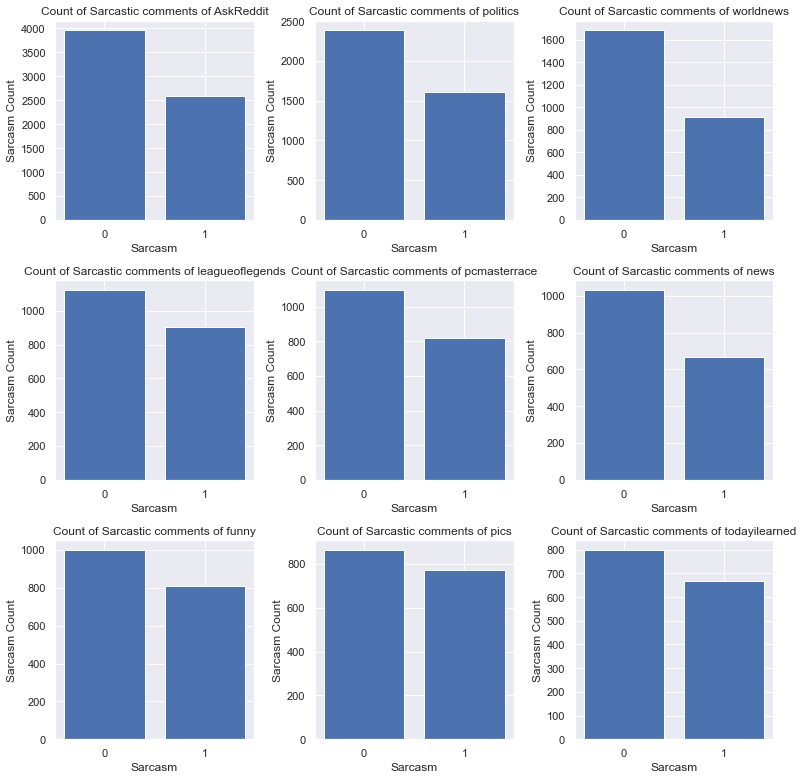

In [58]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('todayilearned')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "GlobalOffensive"')]

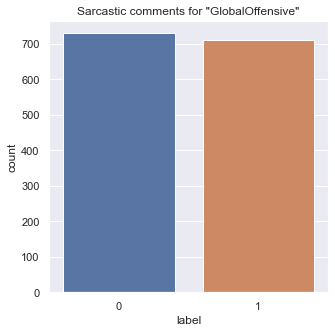

In [59]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [60]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -507, while the highest one is 7563


In [61]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 Facts for those who dispute man-made climate chage: co2 is a greenhouse gas Historically, when co2 went up, the planet warmed. We are producing a lot of co2. We are eliminating much of the plants' and oceans' ability to remove co2 The earth is getting warmer. Now, taking all of those into consideration, there's only one logical conclusion.

 The Comment with the highest score is:
 but it still snows

 sarcastic


In [62]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                             1
comment                                          but it still snows
author                                                       Zoso03
subreddit                                                 worldnews
score                                                          7563
ups                                                              -1
downs                                                            -1
date                                                        2016-12
created_utc                                     2016-12-08 14:53:25
parent_comment    Facts for those who dispute man-made climate c...
Name: 157472, dtype: object

In [63]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 She did the happy dance! Thats how you know shes happy :)

 The Comment with the lowest score is:
 yes...the smiling is irrelevant when trying to tell if she is happy

 sarcastic


In [64]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                             1
comment           yes...the smiling is irrelevant when trying to...
author                                                     Grippler
subreddit                                                       aww
score                                                          -507
ups                                                            -507
downs                                                             0
date                                                        2016-07
created_utc                                     2016-07-16 14:33:06
parent_comment    She did the happy dance! Thats how you know sh...
Name: 305117, dtype: object

Analysis on the scores

In [65]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

6.669548957725299 45.81569164664948


## Text analysis

In [66]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [67]:
red_copy.drop(['author', 'score', 'date', 'created_utc'], axis=1, inplace=True) # rimangono ups and downs
red_copy.head(10)

,label,comment,subreddit,ups,downs,parent_comment
239228,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.
164744,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...
350656,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?
458674,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy"
219246,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.
805101,0,I would rather set fire to the van and crash i...,WeAreTheMusicMakers,3,0,"Have you ever given in to the ""pay to play"" me..."
184353,0,brb quitting my job,leagueoflegends,-1,-1,"A lot, and they are pretty fun. Welcome back t..."
115088,1,Not to mention the poster used a movie made by...,TumblrInAction,-1,-1,So you're admitting to be an unlikeable weirdo...
977602,0,The Matrix?,funny,1,0,I would totally watch a film with that kind of...
518932,1,They also seem to have a pathological fondness...,japan,1,0,"Iranian crime groups sold drugs to 20,000 peop..."


In [68]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char
239228,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20
164744,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175
350656,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48
458674,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44
219246,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31


In [69]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

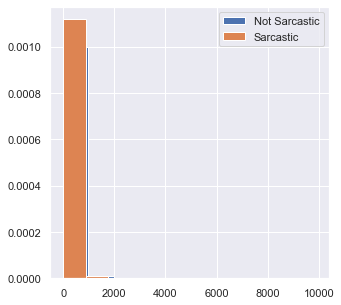

In [70]:
plotDistr('char')

In [71]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct
239228,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1
164744,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1
350656,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2
458674,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2
219246,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1


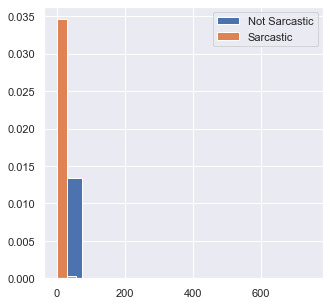

In [72]:
plotDistr('punct')

In [73]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens
239228,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3
164744,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36
350656,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9
458674,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9
219246,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8


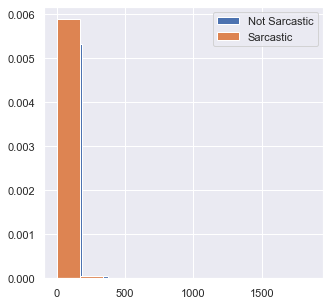

In [74]:
plotDistr('tokens')

In [75]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [76]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [77]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean_comment"] = red_copy["comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [78]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the parent comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the parent comments is: 3.0 minutes and 37.6 seconds


In [79]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram


In [80]:
boh = red_copy[['clean','clean_comment']]

In [81]:
boh["keywords_parent"] = boh["clean"].str.split("[^\w+]").map(set)

boh["keywords_children"] = boh["clean_comment"].str.split("[^\w+]").map(set)
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean,clean_comment,keywords_parent,keywords_children
0,usernam check,wonder make drink believ wholeheart govern,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}"
1,oh god yes terrifi say worst fear loud thought...,ai bitch lol,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}"
2,one trend hope die within year,democraci kid think,"{within, year, one, hope, die, trend}","{democraci, kid, think}"
3,well airspac suck tommi,forget,"{suck, well, airspac, tommi}",{forget}
4,like turn bus,think tram,"{turn, bus, like}","{tram, think}"
...,...,...,...,...
101072,one techniqu make dick grow inch,okay mandingo,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}"
101073,look guy take risk paid,pleas let satir,"{guy, take, paid, look, risk}","{let, pleas, satir}"
101074,understand anyon would want deni human kind lo...,think children,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}"
101075,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}"


In [82]:
boh['common_words'] = [set(x[0].split()) & set(x[1].split()) for x in boh.values]
boh['overlap_count'] = boh['common_words'].str.len()
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,usernam check,wonder make drink believ wholeheart govern,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0
1,oh god yes terrifi say worst fear loud thought...,ai bitch lol,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0
2,one trend hope die within year,democraci kid think,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0
3,well airspac suck tommi,forget,"{suck, well, airspac, tommi}",{forget},{},0
4,like turn bus,think tram,"{turn, bus, like}","{tram, think}",{},0
...,...,...,...,...,...,...
101072,one techniqu make dick grow inch,okay mandingo,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0
101073,look guy take risk paid,pleas let satir,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0
101074,understand anyon would want deni human kind lo...,think children,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0
101075,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0


In [83]:
boh

,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,usernam check,wonder make drink believ wholeheart govern,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0
1,oh god yes terrifi say worst fear loud thought...,ai bitch lol,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0
2,one trend hope die within year,democraci kid think,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0
3,well airspac suck tommi,forget,"{suck, well, airspac, tommi}",{forget},{},0
4,like turn bus,think tram,"{turn, bus, like}","{tram, think}",{},0
...,...,...,...,...,...,...
101072,one techniqu make dick grow inch,okay mandingo,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0
101073,look guy take risk paid,pleas let satir,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0
101074,understand anyon would want deni human kind lo...,think children,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0
101075,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0


In [84]:
#boh['non_common_words'] = [set(x[1].split()) not in set(x[0].split()) for x in boh.values]
#boh['non_overlap_count'] = boh['non_common_words'].str.len()
#boh

### Sentiment Analysis

In [85]:
all_parent_comments = red_copy['parent_comment']
all_sent_values = []
all_sentiments = []

In [86]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [87]:
sample = red_copy['parent_comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

Super Bowl XLIX should be greatest game of all time
Sentiment: 
0.8


In [88]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['parent_comment'][i]))

In [89]:
len(all_sent_values)

101077

In [90]:
all_parent_comments = pd.DataFrame(all_parent_comments)
all_parent_comments

,parent_comment
0,username checks out.
1,Oh my god yes I was terrified to say my worst ...
2,What's one trend you hope dies within this year?
3,"Well it's not his airspace, suck it up Tommy"
4,I like how it turns into a bus.
...,...
101072,This one technique does make your dick grow by...
101073,"Look guys, I take risks and they paid off for ..."
101074,I don't understand why anyone would want to de...
101075,I really hope so. We were winning so seeing a ...


In [91]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>=0.5):
        SENTIMENT.append('Highly Positive')
        SENTIMENT_VALUE.append(5)
    elif (sent<0.5 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(4)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(3)
    elif (sent<0 and sent>=-0.5):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [92]:
all_parent_comments['sentiment_value'] = SENTIMENT_VALUE
all_parent_comments['sentiment'] = SENTIMENT

In [93]:
all_parent_comments

,parent_comment,sentiment_value,sentiment
0,username checks out.,3,Neutral
1,Oh my god yes I was terrified to say my worst ...,2,Negative
2,What's one trend you hope dies within this year?,4,Positive
3,"Well it's not his airspace, suck it up Tommy",5,Highly Positive
4,I like how it turns into a bus.,4,Positive
...,...,...,...
101072,This one technique does make your dick grow by...,2,Negative
101073,"Look guys, I take risks and they paid off for ...",2,Negative
101074,I don't understand why anyone would want to de...,5,Highly Positive
101075,I really hope so. We were winning so seeing a ...,5,Highly Positive


In [94]:
red_final1 = pd.merge(red_copy, all_parent_comments, left_index=True, right_index=True)

In [95]:
red_final = pd.merge(red_final1, boh, left_index=True, right_index=True)

In [96]:
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,parent_comment_y,sentiment_value,sentiment,clean_y,clean_comment_y,keywords_parent,keywords_children,common_words,overlap_count
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,username checks out.,3,Neutral,usernam check,wonder make drink believ wholeheart govern,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,Oh my god yes I was terrified to say my worst ...,2,Negative,oh god yes terrifi say worst fear loud thought...,ai bitch lol,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,What's one trend you hope dies within this year?,4,Positive,one trend hope die within year,democraci kid think,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,"Well it's not his airspace, suck it up Tommy",5,Highly Positive,well airspac suck tommi,forget,"{suck, well, airspac, tommi}",{forget},{},0
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,I like how it turns into a bus.,4,Positive,like turn bus,think tram,"{turn, bus, like}","{tram, think}",{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,This one technique does make your dick grow by...,2,Negative,one techniqu make dick grow inch,okay mandingo,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,"Look guys, I take risks and they paid off for ...",2,Negative,look guy take risk paid,pleas let satir,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,I don't understand why anyone would want to de...,5,Highly Positive,understand anyon would want deni human kind lo...,think children,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,I really hope so. We were winning so seeing a ...,5,Highly Positive,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0


In [97]:
red_final.drop(['parent_comment_y','clean_y','clean_comment_y'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,3,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,2,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,4,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,5,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,4,Positive,"{turn, bus, like}","{tram, think}",{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,2,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,2,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,5,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,5,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0


In [98]:
red_final.rename(columns={'parent_comment_x':'parent_comment','clean_x':'clean','clean_comment_x':'clean_comment'}, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,3,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,2,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,4,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,5,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,4,Positive,"{turn, bus, like}","{tram, think}",{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,2,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,2,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,5,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,5,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0


In [99]:
capital = []

In [100]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['parent_comment'][i].split())))

In [101]:
red_final['cap'] = capital
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,3,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0,0
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,2,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0,3
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,4,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0,0
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,5,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0,0
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,4,Positive,"{turn, bus, like}","{tram, think}",{},0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,2,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0,0
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,2,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0,1
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,5,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0,1
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,5,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0,1


In [102]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,3,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0,0,0
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,2,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0,3,4
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,4,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0,0,1
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,5,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0,0,2
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,4,Positive,"{turn, bus, like}","{tram, think}",{},0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,2,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0,0,1
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,2,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0,1,2
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,5,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0,1,2
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,5,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0,1,2


### Polarity analysis with textblob

In [103]:
red_final[['polarity', 'subjectivity']] = red_final['parent_comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [104]:
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,...,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,...,3,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0,0,0,0.000000,0.000000
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,...,2,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0,3,4,-0.287500,0.837500
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,...,4,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0,0,1,0.000000,0.000000
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,...,5,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0,0,2,0.000000,0.000000
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,...,4,Positive,"{turn, bus, like}","{tram, think}",{},0,1,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,...,2,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0,0,1,0.000000,0.000000
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,...,2,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0,1,2,0.000000,0.000000
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,...,5,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0,1,2,0.216667,0.616667
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,...,5,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0,1,2,0.250000,0.662500


In [105]:
#rated_dummies = pd.get_dummies(red_final.sentiment)

In [106]:
#red_final = pd.concat([red_final, rated_dummies], axis=1)
#red_final

In [108]:
red_final.drop(['sentiment_value'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0,0,0,0.000000,0.000000
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0,3,4,-0.287500,0.837500
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0,0,1,0.000000,0.000000
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0,0,2,0.000000,0.000000
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,Positive,"{turn, bus, like}","{tram, think}",{},0,1,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Okay mandingo,AskReddit,1,0,This one technique does make your dick grow by...,56,1,11,one techniqu make dick grow inch,okay mandingo,Negative,"{make, inch, grow, one, techniqu, dick}","{okay, mandingo}",{},0,0,1,0.000000,0.000000
101073,0,please let this be satire,MaddenUltimateTeam,3,0,"Look guys, I take risks and they paid off for ...",55,2,12,look guy take risk paid,pleas let satir,Negative,"{guy, take, paid, look, risk}","{let, pleas, satir}",{},0,1,2,0.000000,0.000000
101074,1,But think of the children...,pics,1,0,I don't understand why anyone would want to de...,170,3,32,understand anyon would want deni human kind lo...,think children,Highly Positive,"{could, would, anyon, happi, deni, coupl, kind...","{children, think}",{},0,1,2,0.216667,0.616667
101075,0,"same, lost 13 lp due to 2 dcs in my game, we w...",leagueoflegends,1,0,I really hope so. We were winning so seeing a ...,92,2,20,realli hope win see loss promo make realli sad...,lost lp due dcs game stomp hard,Highly Positive,"{lol, make, loss, realli, sad, win, promo, see...","{dcs, lost, due, lp, hard, game, stomp}",{},0,1,2,0.250000,0.662500


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

username checks out.


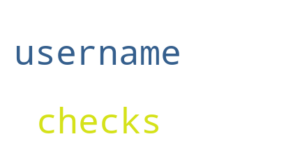

In [109]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_final.parent_comment[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [110]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['parent_comment'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

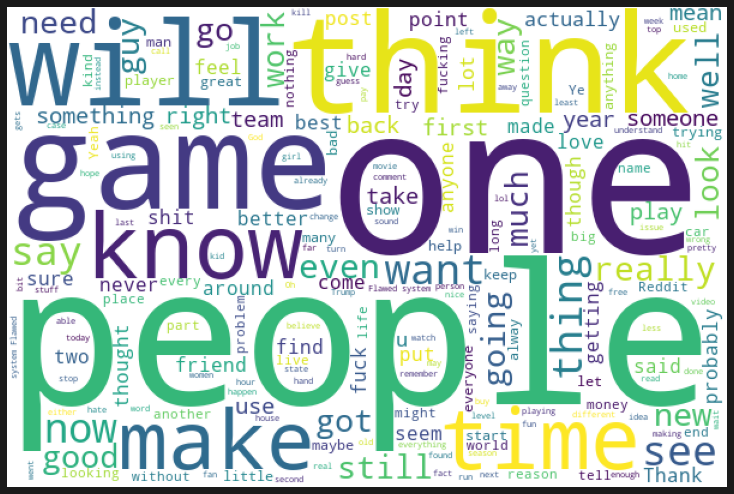

In [111]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

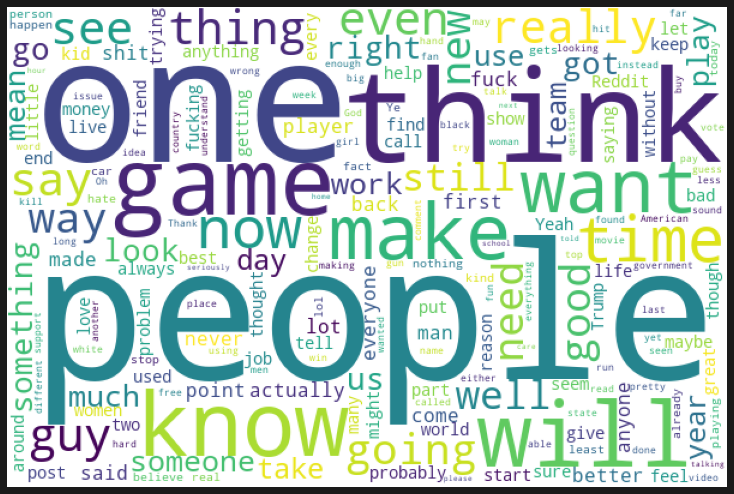

In [112]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [113]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['clean'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

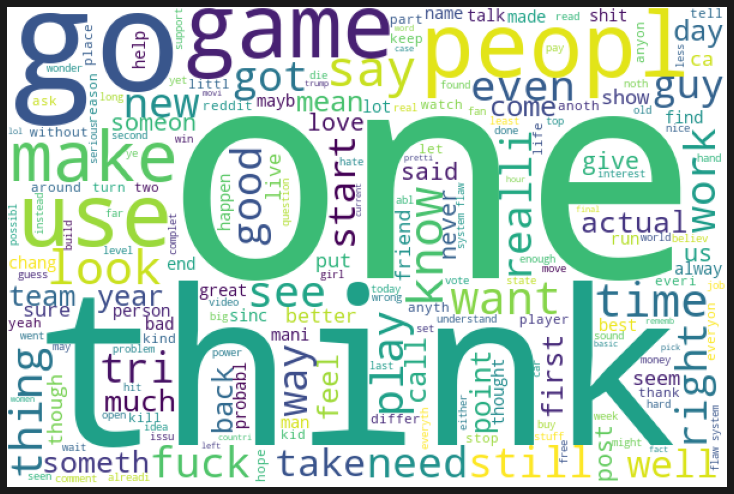

In [114]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

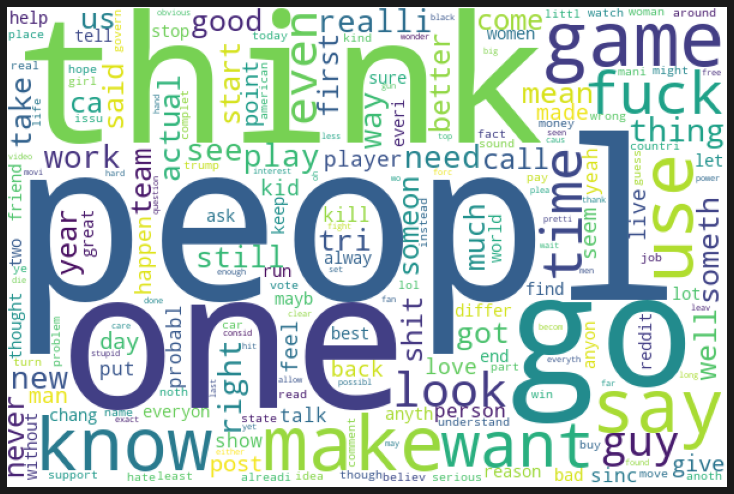

In [115]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [116]:
red_final.rename(columns={'parent_comment':'parent'}, inplace=True)
red_final.head()

,label,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,Neutral,"{check, usernam}","{make, believ, drink, wonder, wholeheart, govern}",{},0,0,0,0.0000,0.0000
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,Negative,"{worst, say, jehovah, loud, might, terrifi, th...","{bitch, ai, lol}",{},0,3,4,-0.2875,0.8375
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,Positive,"{within, year, one, hope, die, trend}","{democraci, kid, think}",{},0,0,1,0.0000,0.0000
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,Highly Positive,"{suck, well, airspac, tommi}",{forget},{},0,0,2,0.0000,0.0000
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,Positive,"{turn, bus, like}","{tram, think}",{},0,1,1,0.0000,0.0000


In [117]:
## Let's check the number of unique values in the subreddit columns
red_final['subreddit'].nunique()

5578

In [118]:
X = red_final.drop(['parent'], axis = 1) 

In [119]:
X = X.drop(['label'], axis = 1) 
y = red_final["label"]

In [120]:
#X = red_copy[['clean','subreddit']]
#y = red_copy['label']

In [121]:
X_train, red_test, y_train1, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [122]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train1, test_size=0.2, random_state=28)

In [123]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(64688, 18)
(16173, 18)
(20216, 18)
(64688,)
(16173,)
(20216,)


In [124]:
red_train.head()

,comment,subreddit,ups,downs,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
72677,#fireBevell #fireCable,Seahawks,2,0,253,14,49,hawkblogg allow sack first game seahawk allow ...,firebevel firec,Positive,"{sack, straight, would, hawkblogg, last, rate,...","{firebevel, firec}",{},0,0,5,0.29,0.36
10531,"Only about 200 times, I'm sure op meant to jus...",gaming,3,0,19,0,3,alreadi post,time sure op meant spread rare post content bit,Neutral,"{alreadi, post}","{spread, op, rare, sure, bit, post, content, m...",{post},1,0,1,0.00,0.00
97566,"He wouldn't have AP holding him back, so he wo...",nfl,15,0,256,8,45,think debat bridg better hoyer almost anyon wo...,would ap hold back would probabl brown,Highly Positive,"{flip, year, almost, debat, would, offens, man...","{would, back, brown, probabl, hold, ap}",{would},1,3,15,0.50,0.50
74802,"A little Comic Sans, perhaps ?",exmormon,3,0,102,2,20,better font like beba futura chosen font bit f...,littl comic san perhap,Highly Positive,"{fun, consid, font, bit, futura, beba, messag,...","{littl, san, perhap, comic}",{},0,0,4,0.40,0.35
54306,They are probably are just hating on them beca...,videos,3,0,195,6,36,love comment youtub cri music like hate nickel...,probabl hate fuck aw internet cred,Highly Positive,"{nickelback, hate, internet, music, comment, t...","{hate, internet, probabl, fuck, aw, cred}","{hate, cred, internet}",3,2,6,0.25,0.70


In [125]:
red_val.head()

,comment,subreddit,ups,downs,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
60690,"Yeah I know, I should have put",pokemongo,-1,-1,74,6,13,uh typic insensit prick found team,yeah know put,Highly Negative,"{team, uh, found, insensit, prick, typic}","{put, know, yeah}",{},0,0,2,-0.166667,0.500000
21264,"It seemed like she was trying too hard to be ""...",popheads,1,0,128,5,26,love bank realli like song bit disjoint tast s...,seem like tri hard weird without concept look ...,Highly Positive,"{excit, new, song, bit, realli, disjoint, supe...","{lol, tri, concept, without, seem, hard, weird...",{like},1,4,10,0.215783,0.611869
28271,Google wants me to crash?,Austin,1,0,41,0,9,realiz mayb case,googl want crash,Neutral,"{case, mayb, realiz}","{want, crash, googl}",{},0,0,1,0.000000,0.000000
41858,"Corporations are people too, my friend.",politics,1,0,57,1,9,mandatori militari servic us citizen,corpor peopl friend,Positive,"{mandatori, servic, citizen, us, militari}","{friend, corpor, peopl}",{},0,1,3,-0.100000,0.100000
68294,"Say, if you're think about doing more of these...",fireemblem,1,0,320,10,61,yeah one point decid lissa staff look whether ...,say think would will take request,Positive,"{well, art, sprite, like, staff, lissa, decid,...","{say, would, take, think, will, request}",{},0,4,14,-0.400000,0.700000


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [126]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [127]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [128]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [129]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [130]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [131]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [132]:
#features = np.append(vectorizer.get_feature_names(), ['char','cap','punt','uppercase'])

In [133]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#### Naive Bayes

In [134]:
naive_bayes = NB.fit(reddit_train, y_train)

In [135]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [136]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5777107241788683

Cross Validation:

In [137]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.56523419, 0.57342711, 0.57365899, 0.56419572, 0.56411842])

#### Logistic Regression

In [138]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [139]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.8s finished


In [140]:
y_pred_logit1 = logit_model1.predict(reddit_test)

Accurcay 0.5699445983379502
Precision 0.5655486296626101
Recall 0.5705160195628306
F1 score 0.5680214647719368


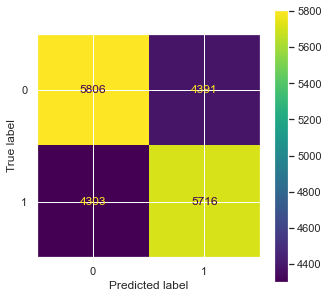

In [141]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test, y_pred_logit1))
print("Precision", precision_score(y_test, y_pred_logit1))
print("Recall",recall_score(y_test, y_pred_logit1))
print("F1 score",f1_score(y_test, y_pred_logit1))
plot_confusion_matrix(logit_model1, reddit_test, y_test)

#### KNN

In [142]:
knn_model1 = knn.fit(reddit_train, y_train) 

In [143]:
y_knn_pred1 = knn_model1.predict(reddit_test)
y_knn_pred1

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [144]:
print(knn_model1.score(reddit_test, y_test)) 

0.5245350217649387


#### Random Forest

In [145]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest_model1 = random_forest.fit(reddit_train, y_train)

In [146]:
randomForest_predict1 = random_forest_model1.predict(reddit_test)

In [147]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.502770083102493

Cross Validation:

In [148]:
rf_cv1 = cross_val_score(random_forest_model1, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.51004792, 0.50888855, 0.50742   , 0.50529489, 0.5182036 ])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [149]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [150]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [151]:
X_sub1 = subreddits_vectorizer.transform(proof['subreddit'])
X_parent1 = parent_vectorizer.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [152]:
X_sent1

<1x54531 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in COOrdinate format>

In [153]:
NB.predict_proba(X_sent1)

array([[0.18783902, 0.81216098]])

In [154]:
logit.predict_proba(X_sent1)

array([[0.32749819, 0.67250181]])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [155]:
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram


In [156]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,text
0,0,I wonder what they make you drink to believe s...,MapPorn,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,usernam check MapPorn
1,0,Ain't that a bitch lol,exjw,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,oh god yes terrifi say worst fear loud thought...
2,1,Democracy... kidding... I think,AskReddit,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,one trend hope die within year AskReddit
3,1,Did you forget the,Multicopter,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,well airspac suck tommi Multicopter
4,0,I was thinking tram.,funny,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,like turn bus funny


In [157]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

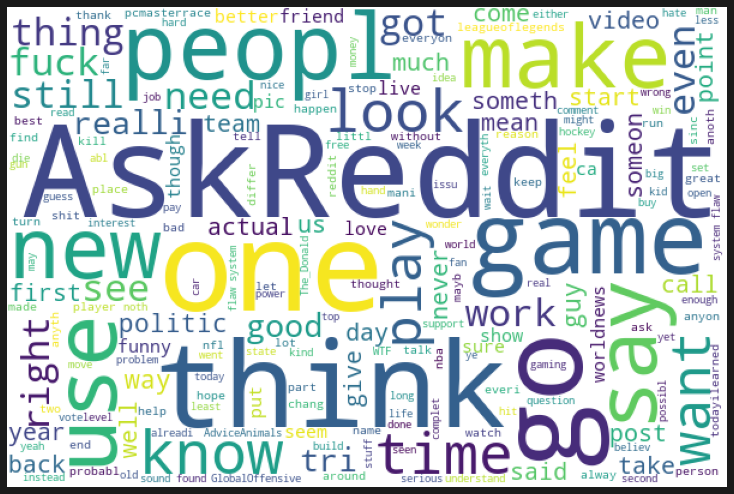

In [158]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

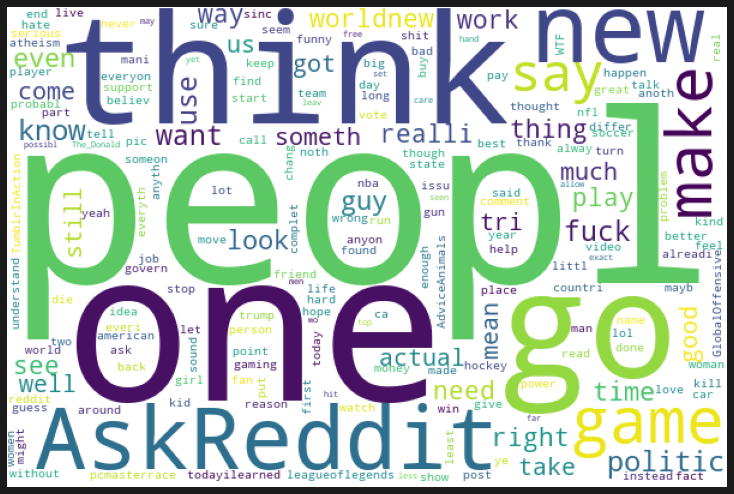

In [159]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [160]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [161]:
X2

,text
0,usernam check MapPorn
1,oh god yes terrifi say worst fear loud thought...
2,one trend hope die within year AskReddit
3,well airspac suck tommi Multicopter
4,like turn bus funny
...,...
101072,one techniqu make dick grow inch AskReddit
101073,look guy take risk paid MaddenUltimateTeam
101074,understand anyon would want deni human kind lo...
101075,realli hope win see loss promo make realli sad...


In [162]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [163]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [164]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [165]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [166]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5716759002770083

Cross Validation:

In [167]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.56433562, 0.56078407, 0.56294831, 0.56690576, 0.56937917])

#### Random forest

In [168]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [169]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [170]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5103383458646616

Cross Validation:

In [171]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.51598343, 0.50575068, 0.51972545, 0.50915162, 0.5106975 ])

#### Logistic Regression

In [172]:
X2 = red_copy['text']
y2 = red_copy['label']

In [173]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [174]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [175]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.7s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [176]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.6010971034998199

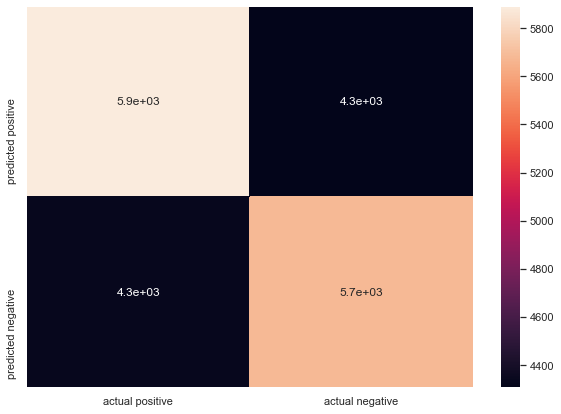

In [177]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's make an example

In [178]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [179]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [180]:
X_parent2 = parent_vectorizer.transform(proof2['text'])

In [181]:
naive_bayes2.predict_proba(X_parent2)

array([[0.49888834, 0.50111166]])

In [182]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [183]:
logit.predict_proba(X_parent2)

array([[0.53762384, 0.46237616]])

#### GridSeachCV:

In [184]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [185]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [186]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    7.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.5s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [187]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [188]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 57.23% 



### Third Alternative

In [189]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [190]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

#### TF-IDF Vectorizers

In [191]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [192]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [193]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [194]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [195]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [196]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [197]:
reddit_train3 = addFeature(reddit_train3, red_train3['overlap_count'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['overlap_count'])
reddit_test3 = addFeature(reddit_test3, red_test3['overlap_count'])

In [198]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [199]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [200]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [201]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [202]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [203]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [204]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [205]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [206]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 57.91%


Confusion matrix:
 [[6586 3611]
 [4897 5122]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


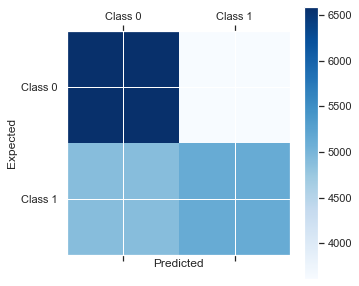

In [207]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [208]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [209]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.6s finished


In [210]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.5459537000395727
Precision 0.5493769104161769
Recall 0.46641381375386765
F1 score 0.5045074224021593


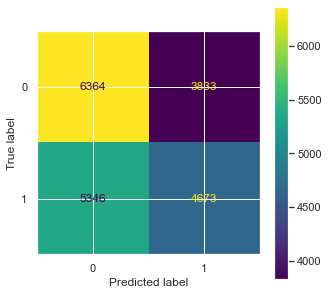

In [211]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [212]:
knn_model3 = knn.fit(reddit_train3, y_train3) 

In [213]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [214]:
print(knn_model3.score(reddit_test3, y_test3)) 

0.5251780767708746


#### Random Forest

In [215]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [216]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [217]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.5181044717055797

Cross Validation

In [218]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.5241923 , 0.52164168, 0.51592209, 0.51356574, 0.50452191])

## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [219]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [220]:
red_copy.replace(replace_sub, inplace=True)

In [221]:
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,text
0,0,I wonder what they make you drink to believe s...,1590,-6,0,username checks out.,20,1,3,usernam check,wonder make drink believ wholeheart govern,usernam check MapPorn
1,0,Ain't that a bitch lol,3656,3,0,Oh my god yes I was terrified to say my worst ...,175,1,36,oh god yes terrifi say worst fear loud thought...,ai bitch lol,oh god yes terrifi say worst fear loud thought...
2,1,Democracy... kidding... I think,227,-2,0,What's one trend you hope dies within this year?,48,2,9,one trend hope die within year,democraci kid think,one trend hope die within year AskReddit
3,1,Did you forget the,1711,0,0,"Well it's not his airspace, suck it up Tommy",44,2,9,well airspac suck tommi,forget,well airspac suck tommi Multicopter
4,0,I was thinking tram.,3798,1,0,I like how it turns into a bus.,31,1,8,like turn bus,think tram,like turn bus funny


In [222]:
## TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(red_copy["clean"])
print(R.shape)
type(R)

(101077, 70946)


scipy.sparse.csr.csr_matrix

In [223]:
#L = vectorizer.fit_transform(red_copy["subreddit"])
#print(R.shape)
#type(R)

In [224]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

In [225]:
R = addFeature(R, red_copy['subreddit'])

In [226]:
print(R.shape)

(101077, 70947)


In [227]:
features = np.append(vectorizer.get_feature_names(), ['Sub'])

In [228]:
features

array(['aa', 'aaa', 'aaa game', ..., 'zyra', 'zzz', 'Sub'], dtype='<U22')

In [229]:
y_label = red_copy['label']

In [230]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_label)
print(R_new.shape)

(101077, 20)


In [231]:
features[selector.get_support()]

array(['american', 'black', 'cat', 'femal', 'gay', 'irl', 'male',
       'muslim', 'peopl', 'racism', 'racist', 'rape', 'roast', 'sarcasm',
       'sarcast', 'thank', 'white', 'woman', 'women', 'Sub'], dtype='<U22')

In [232]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_label)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('Sub', 237689.39194349374, 0.0),
 ('sarcasm', 25.679452860219833, 4.0309609875398827e-07),
 ('white', 24.758138456313205, 6.499378920716796e-07),
 ('peopl', 23.134389279776435, 1.5106463339654543e-06),
 ('thank', 21.766691476985613, 3.078993944329206e-06),
 ('rape', 17.71028133225127, 2.572325212176334e-05),
 ('racist', 16.653120112623064, 4.4876430989757726e-05),
 ('american', 15.018472378302517, 0.00010646394901616844),
 ('woman', 14.902362481250243, 0.00011322110647918383),
 ('women', 14.819736489960578, 0.00011829103195418887),
 ('irl', 13.896597620300273, 0.00019314779743609644),
 ('roast', 13.080843230754068, 0.00029833112619679486),
 ('black', 12.574846031007873, 0.00039097345318863703),
 ('muslim', 12.430174369540364, 0.00042245245658418244),
 ('cat', 11.85221595877019, 0.0005759277210516939),
 ('femal', 11.634407042276612, 0.0006474297800447012),
 ('male', 11.585920436808143, 0.0006645303409240781),
 ('sarcast', 11.314969036176095, 0.0007688474327391868),
 ('racism', 11.3015

In [233]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

<101077x44 sparse matrix of type '<class 'numpy.float64'>'
	with 127102 stored elements in Compressed Sparse Row format>

In [234]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

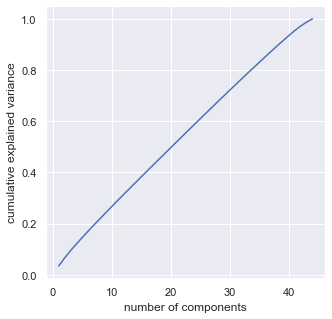

In [236]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()